# Task 1: Loading library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
# Required Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from torch import tensor
from torch.optim import Adam

# Task 2: Loading file

## 2.1 Read csv

In [2]:
# Load the datasets
labeled_data = pd.read_csv('Task2C_labeled.csv')
unlabeled_data = pd.read_csv('Task2C_unlabeled.csv')
test_data = pd.read_csv('Task2C_test.csv')

# Display the first few rows of the datasets to understand their structure
print("Labeled Data:\n", labeled_data.head(3))
print("Unlabeled Data:\n", unlabeled_data.head(3))
print("Test Data:\n", test_data.head(3))



Labeled Data:
    label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0      0        0        0        0        0        0        0        0   
1      7        0        0        0        0        0        0        0   
2      1        0        0        0        0        0        0        0   

   pixel_7  pixel_8  ...  pixel_774  pixel_775  pixel_776  pixel_777  \
0        0        0  ...          0          0          0          0   
1        0        0  ...          0          0          0          0   
2        0        0  ...          0          0          0          0   

   pixel_778  pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  
0          0          0          0          0          0          0  
1          0          0          0          0          0          0  
2          0          0          0          0          0          0  

[3 rows x 785 columns]
Unlabeled Data:
    pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7 

In [3]:
print(f"Labeled Data Rows: {labeled_data.shape[0]}")
print(f"Unlabeled Data Rows: {unlabeled_data.shape[0]}")
print(f"Test Data Rows: {test_data.shape[0]}")

print(f"Labeled Data Cols: {labeled_data.shape[1]}")
print(f"Unlabeled Data Cols: {unlabeled_data.shape[1]}")
print(f"Test Data Cols: {test_data.shape[1]}")


Labeled Data Rows: 50
Unlabeled Data Rows: 1500
Test Data Rows: 500
Labeled Data Cols: 785
Unlabeled Data Cols: 784
Test Data Cols: 785


In [4]:
# Extract features (X) and labels (Y) from the labeled data
X_label = np.array(labeled_data.iloc[:, 1:])  # Features from labeled data
Y_label = np.array(labeled_data.iloc[:, 0])   # Labels from labeled data

# Extract features from the unlabeled data
X_unlabel = np.array(unlabeled_data.iloc[:, :])  # All columns from unlabeled data (no label)

# Combine labeled and unlabeled data for training
X_train = np.concatenate([X_label, X_unlabel], axis=0)

# Extract features (X) and labels (Y) from the test data
X_test = np.array(test_data.iloc[:, 1:])   # Features from test data
Y_test = np.array(test_data.iloc[:, 0])    # Labels from test data


## 2.2 Train Autoencoder model

In [5]:
def normalize(x, mean_value=None, std_value=None): 
    if mean_value is None or std_value is None:
        mean_value, std_value = x.mean(), x.std()
    return (x - mean_value) / std_value

def load_data_train(X_train, Y_train=None, is_autoencoder=False, batch_size=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case is_autoencoder=True, Y_train automatically is set to X_train.
    The function returns the dataloader only if return_dataset is False; otherwise, it returns a tuple (dataloader, train_dataset),
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train = np.array(X_train).astype(np.float32)
        if standardize:
            X_train = normalize(X_train)
        if not is_autoencoder:
            Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Ensure that your input and labels are array-like objects. The input failed with the following exception: %s' % e)
    
    # Transform into tensors
    if is_autoencoder:
        Y_train = X_train
    
    X_train, Y_train = map(tensor, (X_train, Y_train))
    
    device_type = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device_type)
    Y_train = Y_train.to(device_type)
    
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    
    if return_dataset:
        return train_loader, train_dataset
    
    return train_loader

def auto_encoder_train(X_train, hidden_layers, activation_function='Tanh', num_epochs=10, trace_training=True, **kwargs):
    """
    Trains an Autoencoder and returns the trained model
    
    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    hidden_layers: a list of sizes for the hidden layers, e.g., ([100, 2, 100]) will train an autoencoder with 3 layers
    
    activation_function (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    num_epochs: Number of epochs to train autoencoder
    
    trace_training: if true, will display epoch progress and will plot the loss plot at the end of training
    
    **kwargs: passed to Adam optimizer, lookup Adam optimizer for more details
    """
    train_loader = load_data_train(X_train, is_autoencoder=True)
    device_type = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    input_layer_size = [X_train.shape[-1]]
    output_layer_size = input_layer_size
    layer_dimensions = input_layer_size + hidden_layers + output_layer_size
    layers = []
    
    try:
        non_linear_activation = getattr(nn, activation_function)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case-sensitive (e.g., Tanh, Sigmoid, ReLU)')
    
    for i in range(len(layer_dimensions) - 1):
        layers.extend([nn.Linear(layer_dimensions[i], layer_dimensions[i+1]), non_linear_activation])
    
    layers.pop()  # Remove the last non-linearity

    autoencoder_model = nn.Sequential(*layers)
    autoencoder_model = autoencoder_model.to(device_type)
    
    print(f'Training Autoencoder Model on {device_type}')
    
    batch_losses = []
    epoch_loss_history = []
    reconstruction_errors = []
    final_reconstruction_error = []
    optimizer = Adam(autoencoder_model.parameters(), **kwargs)
    mse_loss_criterion = nn.MSELoss()
    
    print_step_interval = int(num_epochs / 10)
    
    for epoch in range(num_epochs):
        for batch_input, batch_output in train_loader:
            predicted_output = autoencoder_model(batch_input)
            loss_value = mse_loss_criterion(predicted_output, batch_output)
            batch_losses.append(loss_value.item())
            loss_value.backward()
            optimizer.step()
            autoencoder_model.zero_grad()

            # Calculate reconstruction error
            X_reconstructed = predicted_output.detach().cpu().numpy()
            batch_output_numpy = batch_output.detach().cpu().numpy()
            batch_reconstruction_distances = np.linalg.norm(batch_output_numpy - X_reconstructed, axis=1)
            reconstruction_errors.append(np.mean(batch_reconstruction_distances))
        
        epoch_loss_value = np.mean(batch_losses[-len(train_loader):])
        epoch_loss_history.append(epoch_loss_value)
        if trace_training and not epoch % print_step_interval:
            print(f'Epoch {epoch} out of {num_epochs}. Loss: {epoch_loss_value}')
    
    final_reconstruction_error.append(np.mean(reconstruction_errors))
    print(final_reconstruction_error)
    
    return autoencoder_model, epoch_loss_history, final_reconstruction_error

def classifier_train(X_train, Y_train, X_test, Y_test, hidden_layers, activation_function='Tanh', num_epochs=10, trace_training=True, **kwargs):
    """
    Trains a feedforward classifier and returns the trained model
    
    Params:
    X_train: Training data to train the classifier. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    Y_train: Training labels. Can be a Series, 1D numpy array, 1-D list or a tensor with 1 dimension
    
    hidden_layers: a list of sizes for the hidden layers ex: ([100, 2, 100]) will train a network with 3 layers
    
    activation_function (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    num_epochs: Number of epochs to train the classifier
    
    trace_training: if true, will display epoch progress and will plot the loss plot at the end of training
    """
    train_loader = load_data_train(X_train, Y_train, is_autoencoder=False)
    X_test_dl = torch.tensor(X_test, dtype=torch.float32)
    Y_test_dl = torch.tensor(Y_test, dtype=torch.long) 
    device_type = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    input_layer_size = [X_train.shape[-1]]
    output_layer_size = [len(np.unique(Y_train))]
    layer_dimensions = input_layer_size + hidden_layers + output_layer_size
    layers = []
    
    try:
        non_linear_activation = getattr(nn, activation_function)()
    except AttributeError:
        raise Exception('Activation function not found, note that it is case-sensitive (e.g., Tanh, Sigmoid, ReLU)')
    
    for i in range(len(layer_dimensions) - 1):
        layers.extend([nn.Linear(layer_dimensions[i], layer_dimensions[i+1]), non_linear_activation])
    
    layers.pop()

    classifier_model = nn.Sequential(*layers)
    classifier_model = classifier_model.to(device_type)
    
    print(f'Training Classifier Model on {device_type}')
    
    batch_losses = []
    epoch_loss_history = []
    test_epoch_losses = []
    
    optimizer = Adam(classifier_model.parameters(), **kwargs)
    loss_function = nn.CrossEntropyLoss()
    print_step_interval = int(num_epochs / 10)
    
    for epoch in range(num_epochs):
        for batch_input, batch_label in train_loader:
            predictions = classifier_model(batch_input)
            loss = loss_function(predictions, batch_label)
            batch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            classifier_model.zero_grad()
        
        with torch.no_grad():
            test_predictions = classifier_model(X_test_dl.to(device_type))
            test_loss = loss_function(test_predictions, Y_test_dl.to(device_type).long())
            test_epoch_losses.append(test_loss)
        
        epoch_loss_train = np.mean(batch_losses[-len(train_loader):])
        epoch_loss_history.append(epoch_loss_train)
        
        if trace_training and not epoch % print_step_interval:
            print(f'Epoch {epoch} out of {num_epochs}. Loss: {epoch_loss_train}')
    
    return classifier_model, epoch_loss_history, test_epoch_losses


In [7]:
# Define training parameters
num_epochs = 10  # Number of epochs for training
learning_rate = 0.001  # Learning rate for optimizer
activation_function = 'Tanh'  # Activation function used in hidden layers
hidden_neurons_list = list(range(20, 260, 40))  # List of different hidden neuron configurations to experiment with

# Initialize arrays to store models, final losses, hidden units, and reconstruction errors for labeled data
models_label = np.empty(shape=(len(hidden_neurons_list), 1), dtype=object) 
final_losses_label = np.zeros(shape=(len(hidden_neurons_list), 1))  
hidden_units_label = np.empty(shape=(len(hidden_neurons_list), 1), dtype=list) 
reconstruction_error_label = np.empty(shape=(len(hidden_neurons_list), 1))  

# Train the autoencoder for each hidden neuron configuration
for i, num_hidden_neurons in enumerate(hidden_neurons_list):
    hidden_layers = [num_hidden_neurons]  # Set hidden layer configuration for this iteration
    
    # Train the autoencoder with the current hidden layer configuration
    res_label = auto_encoder_train(
        X_train=X_train,  # Corrected parameter name to 'X_train'
        hidden_layers = hidden_layers,  # Current hidden layer configuration
        num_epochs=num_epochs,  # Number of training epochs
        activation_function=activation_function,  # Activation function
        lr=learning_rate,  # Learning rate
        trace_training=False  # Whether to display training progress
    )
    
    # Unpack the results from training
    model_label, loss_trajectory_label, reconstruction_error_label_current = res_label
    
    # Store the model, final loss, hidden units, and reconstruction error for the current configuration
    models_label[i, 0] = model_label
    final_losses_label[i, 0] = loss_trajectory_label[-1]  
    hidden_units_label[i, 0] = hidden_layers 
    reconstruction_error_label[i, 0] = reconstruction_error_label_current[0] 
    # Output the final loss for this configuration
    print(f'Labeled final loss for {num_hidden_neurons} hidden neurons = {loss_trajectory_label[-1]}')


Training Autoencoder Model on cpu
[np.float32(23.741625)]
Labeled final loss for 20 hidden neurons = 0.6003350890599765
Training Autoencoder Model on cpu
[np.float32(20.468721)]
Labeled final loss for 60 hidden neurons = 0.3930640656214494
Training Autoencoder Model on cpu
[np.float32(18.587597)]
Labeled final loss for 100 hidden neurons = 0.2961691709665152
Training Autoencoder Model on cpu
[np.float32(17.187004)]
Labeled final loss for 140 hidden neurons = 0.23373455840807694
Training Autoencoder Model on cpu
[np.float32(16.21606)]
Labeled final loss for 180 hidden neurons = 0.1966790373508747
Training Autoencoder Model on cpu
[np.float32(15.337811)]
Labeled final loss for 220 hidden neurons = 0.1662964872442759


## 2.3: Plot the effect of reconstruction error

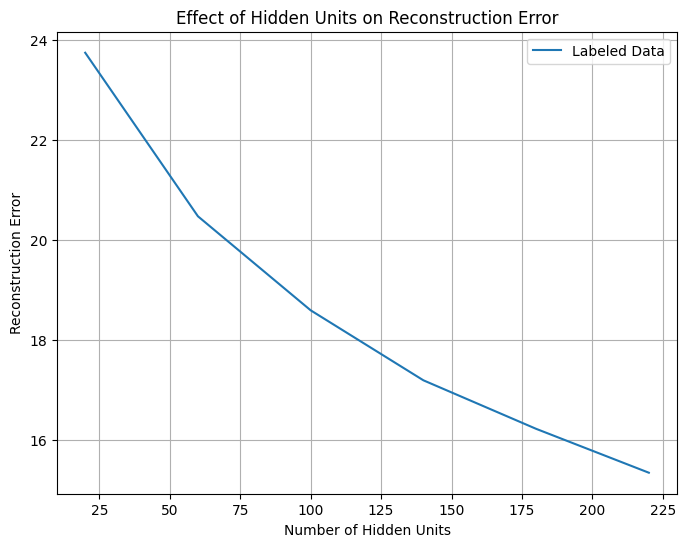

In [8]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, axs = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(8)

# Plot the reconstruction error for labeled data
axs.plot(hidden_neurons_list, reconstruction_error_label, label='Labeled Data')

# Optionally plot for unlabeled data if needed (commented out)
# axs.plot(hidden_neurons_list, reconstruction_error_unlabeled, label='Unlabeled Data')

# Add legend, labels, and title
axs.legend()
axs.set_xlabel('Number of Hidden Units')
axs.set_ylabel('Reconstruction Error')
axs.set_title('Effect of Hidden Units on Reconstruction Error')

# Add a grid
axs.grid(True)

# Show the plot
plt.show()


**Finding**

Overall, the reconstruction error decreases gradually as the number of units increases. This indicates that a larger number of units may increase the ability of the autoencoder and allow it to better reconstruct features. In constrast, we can see from the plot that there is less deep steep between 50-75 hidden units and this continues till 225.

## 2.4 Build 3-layer NN

In [9]:
# Define constants for training
num_epochs = 10  
activation_function = 'Tanh'  
hidden_neurons_list = list(range(20, 260, 40))  

# Extract labels from the labeled dataset
Y_label = labeled_data.iloc[:, 0]  # The first column represents labels

# Initialize arrays to store trained models, training losses, test losses, and hidden units
trained_models_classifier = np.empty(shape=(len(hidden_neurons_list), 1), dtype=object) 
train_losses_classifier = np.zeros(shape=(len(hidden_neurons_list), 1))  
test_losses_classifier = np.zeros(shape=(len(hidden_neurons_list), 1))  
hidden_units_classifier = np.empty(shape=(len(hidden_neurons_list), 1))  

# Loop through the different hidden layer sizes and train the classifier
for i, neurons in enumerate(hidden_neurons_list):
    hidden_layers = [neurons]
    print(f'Hidden Layers = {hidden_layers}')
    
    # Train the classifier on labeled data
    result_classifier = classifier_train(    
        X_train=X_label,  # Training data features
        Y_train=Y_label,  # Training data labels
        X_test=X_test,  # Test data features
        Y_test=Y_test,  # Test data labels
        hidden_layers=hidden_layers,  
        num_epochs=num_epochs, 
        activation_function=activation_function,  
        trace_training=False  
    )

    # Extract the results
    model_classifier, loss_trajectory_classifier, loss_test_classifier = result_classifier
    trained_models_classifier[i, 0] = model_classifier
    train_losses_classifier[i, 0] = loss_trajectory_classifier[-1]
    test_losses_classifier[i, 0] = loss_test_classifier[-1]
    hidden_units_classifier[i, 0] = neurons
    
    print(f'CrossEntropyLoss = {loss_test_classifier[-1]}')


Hidden Layers = [20]
Training Classifier Model on cpu
CrossEntropyLoss = 1.8399500846862793
Hidden Layers = [60]
Training Classifier Model on cpu
CrossEntropyLoss = 1.5777673721313477
Hidden Layers = [100]
Training Classifier Model on cpu
CrossEntropyLoss = 1.533036470413208
Hidden Layers = [140]
Training Classifier Model on cpu
CrossEntropyLoss = 1.377916693687439
Hidden Layers = [180]
Training Classifier Model on cpu
CrossEntropyLoss = 1.2616077661514282
Hidden Layers = [220]
Training Classifier Model on cpu
CrossEntropyLoss = 1.243679404258728


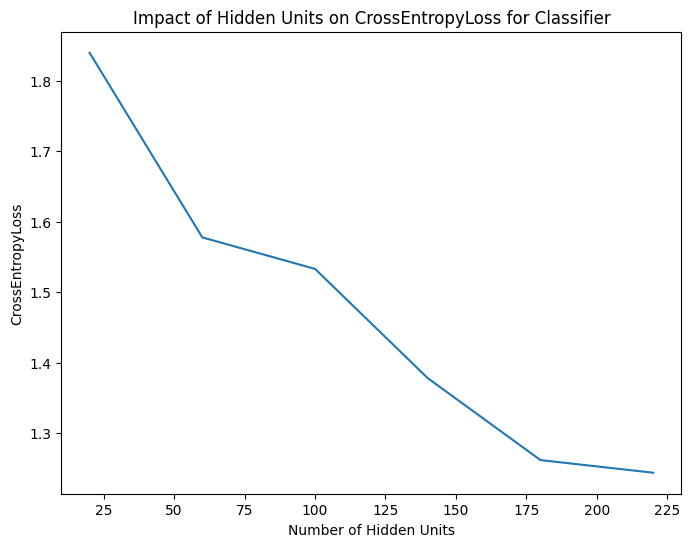

In [10]:
# Create a figure and an axis for the plot
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(8)

# Plot the test losses for different hidden units
ax.plot(hidden_neurons_list, test_losses_classifier)

# Set labels and title for the plot
ax.set_xlabel('Number of Hidden Units')
ax.set_ylabel('CrossEntropyLoss')
ax.set_title('Impact of Hidden Units on CrossEntropyLoss for Classifier')

# Display the plot
plt.show()


## 2.5  Build augmented self-taught networks

In [11]:
def load_deep_features(trained_network, input_data, layer_index):
    """
    Gets deep features of a given `layer_index` upon passing `input_data` through a `trained_network`
    """
    input_data = load_data_train(input_data, is_autoencoder=True, return_dataset=True)[1].tensors[0]
    layer_output = []

    def capture_output(module, input, output):
        layer_output.append(output.data)
    
    forward_hook = trained_network[layer_index].register_forward_hook(capture_output)
    
    with torch.no_grad():
        trained_network(input_data)

    forward_hook.remove()
    
    return layer_output[0].cpu().numpy()


### Add extra features to original dataset

In [12]:
new_features_label = []  
new_features_test = []

# Iterate over the trained models for labeled data
for i, model in enumerate(models_label):  
    # Extract deep features from the model for labeled data
    deep_features_label = load_deep_features(model[0], np.array(labeled_data.iloc[:, 1:]), layer_index=1)  
    
    # Extract deep features from the model for test data
    deep_features_test = load_deep_features(model[0], X_test, layer_index=1)  
    
    # Combine original labeled data features with deep features
    new_features_label.append(np.hstack((np.array(labeled_data.iloc[:, 1:]), deep_features_label)))  
    
    # Combine original test data features with deep features
    new_features_test.append(np.hstack((X_test, deep_features_test)))  


### Train a new 3-layer Neural Network and calculate / record the test error

In [13]:
epochs = 10
activation_function = 'Tanh' 
models_classifier_extra = np.empty(shape=(len(hidden_neurons_list), 1), dtype=object) 
losses_classifier_extra = np.zeros(shape=(len(hidden_neurons_list), 1))  
losses_classifier_test_extra = np.zeros(shape=(len(hidden_neurons_list), 1))  
hidden_units_classifier_extra = np.empty(shape=(len(hidden_neurons_list), 1)) 

for i, num_hidden_neurons in enumerate(hidden_neurons_list):  
    hidden_layers = [num_hidden_neurons]  
    print('Hidden={0}'.format(hidden_layers))
    
    # Train the classifier
    res_classifier_extra = classifier_train(    
        X_train=new_features_label[i],  
        Y_train=Y_label,  
        X_test=new_features_test[i],  
        Y_test=Y_test,  
        hidden_layers=hidden_layers,  
        num_epochs=epochs, 
        activation_function=activation_function,  
        trace_training=False  
    )
    
    model_classifier_extra, loss_trajectory_extra, loss_test_extra = res_classifier_extra  

    # Store the trained model and losses
    models_classifier_extra[i, 0] = model_classifier_extra
    losses_classifier_extra[i, 0] = loss_trajectory_extra[-1]
    losses_classifier_test_extra[i, 0] = loss_test_extra[-1]
    hidden_units_classifier_extra[i, 0] = num_hidden_neurons
    
    print('CrossEntropyLoss = {0}'.format(loss_test_extra[-1]))


Hidden=[20]
Training Classifier Model on cpu
CrossEntropyLoss = 1.798496127128601
Hidden=[60]
Training Classifier Model on cpu
CrossEntropyLoss = 1.5355075597763062
Hidden=[100]
Training Classifier Model on cpu
CrossEntropyLoss = 1.3592089414596558
Hidden=[140]
Training Classifier Model on cpu
CrossEntropyLoss = 1.358269214630127
Hidden=[180]
Training Classifier Model on cpu
CrossEntropyLoss = 1.3134061098098755
Hidden=[220]
Training Classifier Model on cpu
CrossEntropyLoss = 1.2613407373428345


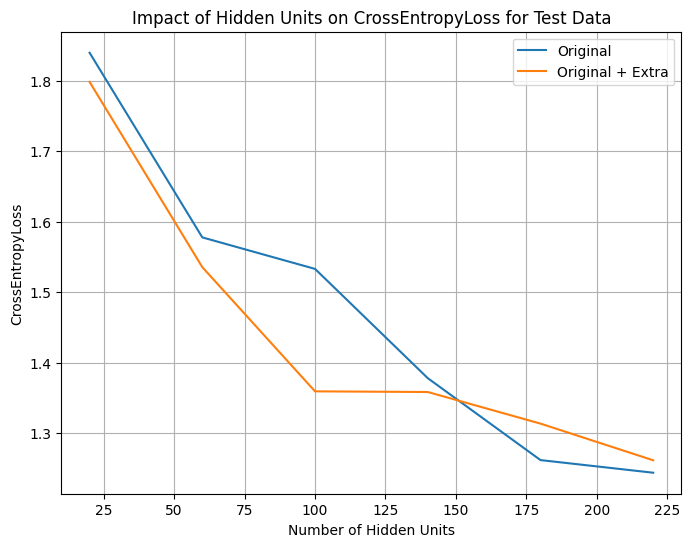

In [14]:
# Create a figure and axes
fig, axs = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(8)

# Plot CrossEntropyLoss for the first line (Original)
axs.plot(hidden_neurons_list, test_losses_classifier , label='Original')  # Plot for 'Original'

# Plot CrossEntropyLoss for the second line (Original + Extra)
axs.plot(hidden_neurons_list, losses_classifier_test_extra, label='Original + Extra')  # Plot for 'Original + Extra'

# Add legend to distinguish the lines
axs.legend()

# Set the labels and new title
axs.set_xlabel('Number of Hidden Units')  # Updated the label
axs.set_ylabel('CrossEntropyLoss')  # Label remains the same
axs.set_title('Impact of Hidden Units on CrossEntropyLoss for Test Data')  # New title

# Add a grid
axs.grid(True)

# Show the plot
plt.show()


**Key Observations:**

- Performance Boost with Extra Features: The model with additional autoencoder features (orange line) consistently performs better, with lower CrossEntropyLoss compared to the original model (blue line) across all hidden unit configurations.
- Loss Reduction: At 25 hidden units, the loss drops from 1.8 to 1.7 for the original model and from 1.8 to 1.6 for the enhanced model. By 175 hidden units, the loss decreases to around 1.3 for both models, with the enhanced model maintaining a slight advantage.
- Optimal Range: The most noticeable improvement occurs between 25 and 100 hidden units. Beyond 100 units, both models continue to improve, but the gains are smaller.
- Conclusion: Adding features through an autoencoder significantly improves model performance, especially in the lower hidden unit ranges. The extra features allow the model to capture more data patterns, resulting in consistently lower errors.
